In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Parametros

In [2]:
START_DATE = "2015-01-30"
INITIAL_CAPITAL = 250_000
RISK_FREE_RATE = 0.02  # 2% anual

## Carga de datos cartera

In [3]:
portfolio_daily = pd.read_parquet("resources/portfolio_daily.parquet")
parquet = pd.read_parquet("resources/assignment_parquet.parquet")

## Descarga de datos SPY

In [4]:
spy = yf.download("SPY", start=START_DATE, end="2026-01-31", auto_adjust=True)
# eliminamos el nivel extra
spy.columns = spy.columns.droplevel(1)
spy.index.name = 'date'
spy = spy.reset_index()

[*********************100%***********************]  1 of 1 completed


## Retornos diarios de la estrategia

In [5]:
portfolio_daily['daily_return'] = portfolio_daily['portfolio_value'].pct_change()

## Retornos diarios del SPY como benchmark

In [6]:
spy['daily_return'] = spy['Close'].pct_change()

In [7]:
print(f"Días estrategia: {len(portfolio_daily)}")
print(f"Días SPY: {len(spy)}")
print(f"SPY precio inicial: ${spy['Close'].iloc[0]:,.2f}")
print(f"SPY precio final:   ${spy['Close'].iloc[-1]:,.2f}")
print(f"SPY retorno acumulado: {(spy['Close'].iloc[-1] / spy['Close'].iloc[0] - 1) * 100:.2f}%")

Días estrategia: 2766
Días SPY: 2767
SPY precio inicial: $165.62
SPY precio final:   $691.97
SPY retorno acumulado: 317.80%


## Métricas

In [8]:
n_years = (portfolio_daily['date'].iloc[-1] - portfolio_daily['date'].iloc[0]).days / 365.25

### CAGR

In [9]:
cagr_strategy = (portfolio_daily['portfolio_value'].iloc[-1] / INITIAL_CAPITAL) ** (1 / n_years) - 1
cagr_spy = (spy['Close'].iloc[-1] / spy['Close'].iloc[0]) ** (1 / n_years) - 1

### Volatilidad anualizada

In [10]:
vol_strategy = portfolio_daily['daily_return'].std() * np.sqrt(252)
vol_spy = spy['daily_return'].std() * np.sqrt(252)

### Sharpe

In [11]:
sharpe_strategy = (cagr_strategy - RISK_FREE_RATE) / vol_strategy
sharpe_spy = (cagr_spy - RISK_FREE_RATE) / vol_spy

### Sortino

In [12]:
neg_strategy = portfolio_daily['daily_return'][portfolio_daily['daily_return'] < 0].std() * np.sqrt(252)
neg_spy = spy['daily_return'][spy['daily_return'] < 0].std() * np.sqrt(252)
sortino_strategy = (cagr_strategy - RISK_FREE_RATE) / neg_strategy
sortino_spy = (cagr_spy - RISK_FREE_RATE) / neg_spy

### Max Drawdown

#### Cartera

In [13]:
rolling_max = portfolio_daily['portfolio_value'].cummax()
drawdown = (portfolio_daily['portfolio_value'] - rolling_max) / rolling_max
max_dd_strategy = drawdown.min()

#### SPY

In [14]:
rolling_max_spy = spy['Close'].cummax()
drawdown_spy = (spy['Close'] - rolling_max_spy) / rolling_max_spy
max_dd_spy = drawdown_spy.min()

## Resultados

In [15]:
print(f"{'':20} {'Estrategia':>12} {'SPY':>12}")
print(f"{'─'*44}")
print(f"{'CAGR':20} {cagr_strategy:>11.2%} {cagr_spy:>11.2%}")
print(f"{'Volatilidad':20} {vol_strategy:>11.2%} {vol_spy:>11.2%}")
print(f"{'Sharpe':20} {sharpe_strategy:>11.2f} {sharpe_spy:>11.2f}")
print(f"{'Sortino':20} {sortino_strategy:>11.2f} {sortino_spy:>11.2f}")
print(f"{'Max Drawdown':20} {max_dd_strategy:>11.2%} {max_dd_spy:>11.2%}")

                       Estrategia          SPY
────────────────────────────────────────────
CAGR                      17.82%      13.88%
Volatilidad               27.24%      17.75%
Sharpe                      0.58        0.67
Sortino                     0.73        0.81
Max Drawdown             -39.08%     -33.72%


## Beta y Alpha

In [16]:
merged = portfolio_daily[['date', 'daily_return']].merge(spy[['date', 'daily_return']], on='date', suffixes=('_strategy', '_spy'))
merged = merged.dropna()

cov = np.cov(merged['daily_return_strategy'], merged['daily_return_spy'])
beta = cov[0, 1] / cov[1, 1]
alpha = cagr_strategy - (RISK_FREE_RATE + beta * (cagr_spy - RISK_FREE_RATE))

print(f"{'Beta':20} {beta:>11.2f}")
print(f"{'Alpha':20} {alpha:>11.2%}")

Beta                        1.13
Alpha                      2.38%


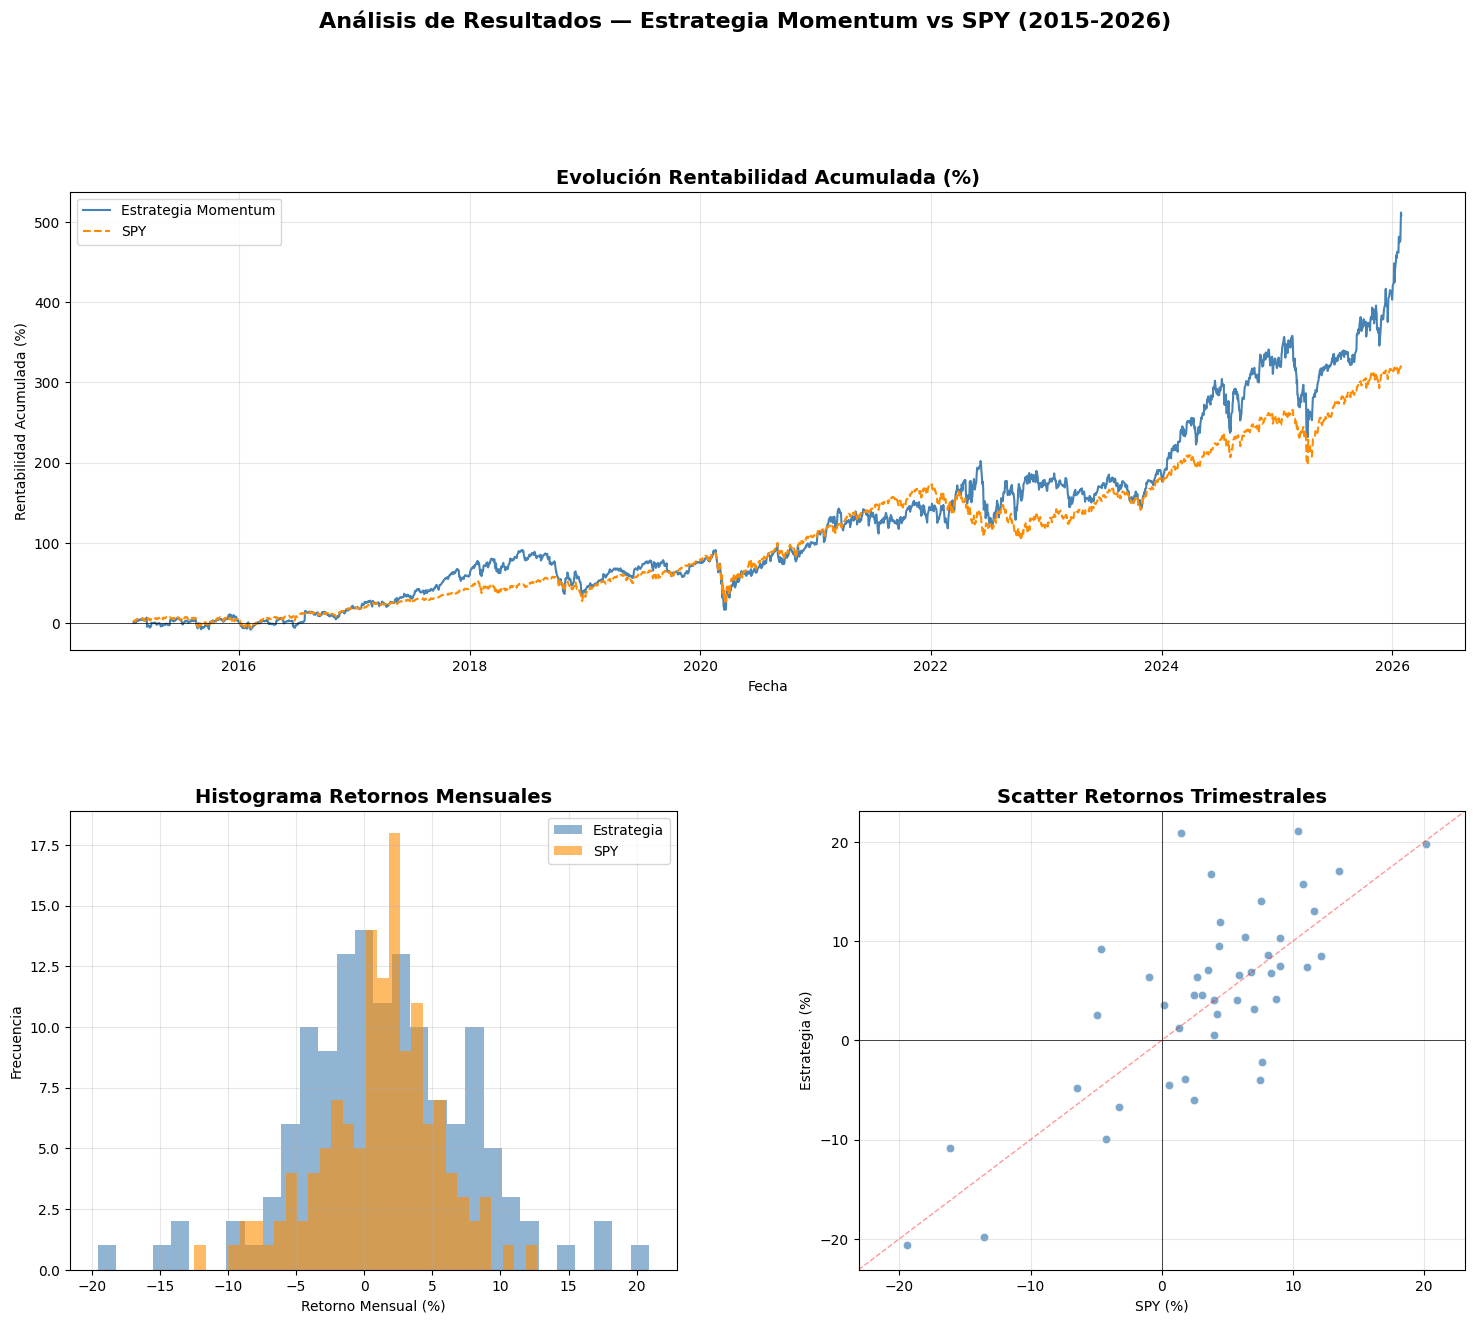

In [17]:
# Preparamos retornos mensuales y anuales/trimestrales
portfolio_daily['year'] = portfolio_daily['date'].dt.year
portfolio_daily['quarter'] = portfolio_daily['date'].dt.to_period('Q')
portfolio_daily['month'] = portfolio_daily['date'].dt.to_period('M')

spy['year'] = spy['date'].dt.year
spy['quarter'] = spy['date'].dt.to_period('Q')
spy['month'] = spy['date'].dt.to_period('M')

# Retornos mensuales
monthly_strategy = portfolio_daily.groupby('month')['daily_return'].apply(lambda x: (1+x).prod()-1)
monthly_spy = spy.groupby('month')['daily_return'].apply(lambda x: (1+x).prod()-1)

# Retornos trimestrales
quarterly_strategy = portfolio_daily.groupby('quarter')['daily_return'].apply(lambda x: (1+x).prod()-1)
quarterly_spy = spy.groupby('quarter')['daily_return'].apply(lambda x: (1+x).prod()-1)

# Retornos anuales
annual_strategy = portfolio_daily.groupby('year')['daily_return'].apply(lambda x: (1+x).prod()-1)
annual_spy = spy.groupby('year')['daily_return'].apply(lambda x: (1+x).prod()-1)

# Rentabilidad acumulada
portfolio_daily['cum_return'] = (1 + portfolio_daily['daily_return']).cumprod() - 1
spy['cum_return'] = (1 + spy['daily_return']).cumprod() - 1

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.3)

# --- GRÁFICO 1: Rentabilidad acumulada ---
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(portfolio_daily['date'], portfolio_daily['cum_return'] * 100,
         label='Estrategia Momentum', color='steelblue', linewidth=1.5)
ax1.plot(spy['date'], spy['cum_return'] * 100,
         label='SPY', color='darkorange', linewidth=1.5, linestyle='--')
ax1.set_title('Evolución Rentabilidad Acumulada (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Rentabilidad Acumulada (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.5)

# --- GRÁFICO 2: Histograma retornos mensuales ---
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(monthly_strategy * 100, bins=30, alpha=0.6, color='steelblue', label='Estrategia')
ax2.hist(monthly_spy * 100, bins=30, alpha=0.6, color='darkorange', label='SPY')
ax2.set_title('Histograma Retornos Mensuales', fontsize=14, fontweight='bold')
ax2.set_xlabel('Retorno Mensual (%)')
ax2.set_ylabel('Frecuencia')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- GRÁFICO 3: Scatter trimestrales ---
ax3 = fig.add_subplot(gs[1, 1])
common_q = quarterly_strategy.index.intersection(quarterly_spy.index)
ax3.scatter(quarterly_spy[common_q] * 100, quarterly_strategy[common_q] * 100,
            color='steelblue', alpha=0.7, edgecolors='white', linewidth=0.5)
lim = max(abs(quarterly_spy[common_q].min()), abs(quarterly_spy[common_q].max()),
          abs(quarterly_strategy[common_q].min()), abs(quarterly_strategy[common_q].max())) * 100 + 2
ax3.axhline(0, color='black', linewidth=0.5)
ax3.axvline(0, color='black', linewidth=0.5)
ax3.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.4, linewidth=1)
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)
ax3.set_title('Scatter Retornos Trimestrales', fontsize=14, fontweight='bold')
ax3.set_xlabel('SPY (%)')
ax3.set_ylabel('Estrategia (%)')
ax3.grid(True, alpha=0.3)

plt.suptitle('Análisis de Resultados — Estrategia Momentum vs SPY (2015-2026)',
             fontsize=16, fontweight='bold', y=1.01)

plt.savefig('resources/visualizaciones.png', dpi=150, bbox_inches='tight')
plt.show()